## Predicción del próximo caracter

El objetivo de este notebook es entrenar un modelo de lenguaje basado en arquitecturas recurrentes a partir de un corpus.

La fuente de datos a utilizar es un dataset consistente en transcriptiones de TED Talks en inglés. El mismo puede hallarse el el siguiente link: [Kaggle - TED Talks](https://www.kaggle.com/datasets/miguelcorraljr/ted-ultimate-dataset)

En el transcurso del ejercicio se explorarán técnicas de generación de secuencias y se medirá la calidad de las mismas calculando la *perplejidad*.
Una vez entrenado el modelo, se lo empleará para generar los siguientes $\mathit{n}$ caracteres, dada una secuencia de inicio.

Se incluye, además, una implementación de Beam Search para generar secuencias sobre el mismo dataset.

### Librerías

In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from scipy.special import softmax

from matplotlib import pyplot as plt
import seaborn as sns

### Carga de datos y preprocesamiento

In [2]:
# !pip install gdown
!gdown 1D1XSN3V-Oq_OQhYFmaQeu8CgfqY_8O-L

Downloading...
From: https://drive.google.com/uc?id=1D1XSN3V-Oq_OQhYFmaQeu8CgfqY_8O-L
To: /content/ted_talks_en.csv
100% 45.5M/45.5M [00:00<00:00, 147MB/s]


In [3]:
df = pd.read_csv('ted_talks_en.csv')

# Filtrar el dataframe tomando sólo las TED Talks que tienen a "computers" entre sus tópicos.
# Tomar sólo 30 registros para evitar exceder la memoria disponible en Colab.
df = df[df['topics'].apply(lambda x: 'computers' in x)][['transcript']].iloc[:30]
print('\nCantidad de documentos:', df.shape[0])
df.head()


Cantidad de documentos: 30


,transcript
2,"(Music: ""The Sound of Silence,"" Simon & Garfun..."
59,This meeting has really been about a digital r...
104,I do two things: I design mobile computers and...
155,There's an ancient and universal concept that ...
194,"A great way to start, I think, with my view of..."


In [4]:
# Guardar cada oración en una lista.
text = list(df.loc[:, 'transcript'])
text[0]

'(Music: "The Sound of Silence," Simon & Garfunkel) Hello voice mail, my old friend. (Laughter) I\'ve called for tech support again. I ignored my boss\'s warning. I called on a Monday morning. Now it\'s evening, and my dinner first grew cold, and then grew mold. I\'m still on hold. I\'m listening to the sounds of silence. I don\'t think you understand. I think your phone lines are unmanned. I punched every touch tone I was told, but I\'ve still spent 18 hours on hold. It\'s not enough your software crashed my Mac, and it constantly hangs and bombs — it erased my ROMs! Now the Mac makes the sounds of silence. In my dreams I fantasize of wreaking vengeance on you guys. Say your motorcycle crashes. Blood comes gushing from your gashes. With your fading strength, you call 9-1-1 and you pray for a trained MD. But you get me. (Laughter) And you listen to the sounds of silence. (Music) (Applause) Thank you. Good evening and welcome to: "Spot the TED Presenter Who Used to Be a Broadway Accompa

In [5]:
# Tamaño de contexto.
max_context_size = 100

# Vocabulario como conjunto único de caracteres que existe en todo el texto.
full_text = '. '.join(text).lower()
chars_vocab = set(full_text)
len(chars_vocab)

56

In [6]:
# Diccionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v, k in enumerate(chars_vocab)}
idx2char = {v: k for k, v in char2idx.items()}

### Tokenizar

In [7]:
# Tokenización del texto completo
tokenized_text = [char2idx[ch] for ch in full_text]
tokenized_text[:10]


[52, 14, 11, 43, 13, 3, 34, 47, 32, 30]

### Dividir el dataset

In [8]:
# Separar el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación.
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación.
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text) * p_val / max_context_size))

# Separar la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val * max_context_size]
val_text = tokenized_text[-num_val * max_context_size:]

tokenized_sentences_val = [val_text[init * max_context_size:init * (max_context_size + 1)] for init in range(num_val)]
tokenized_sentences_train = [train_text[init:init + max_context_size] for init in range(len(train_text) - max_context_size + 1)]

X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

X.shape

(379674, 100)

In [9]:
X[0, :10]

array([52, 14, 11, 43, 13,  3, 34, 47, 32, 30])

In [10]:
y.shape

(379674, 100)

In [11]:
y[0, :10]

array([14, 11, 43, 13,  3, 34, 47, 32, 30, 21])

In [12]:
vocab_size = len(chars_vocab)
vocab_size

56

### Definir el modelo

In [13]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode='one_hot'), input_shape=(None, 1)))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.3))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 56)          0         
 ributed)                                                        
                                                                 
 lstm (LSTM)                 (None, None, 100)         62800     
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 dense (Dense)               (None, None, 56)          5656      
                                                                 
Total params: 68456 (267.41 KB)
Trainable params: 68456 (267.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Definir como callback a la métrica perplexity

In [14]:
class PplCallback(keras.callbacks.Callback):
    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = history_ppl
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq) != 0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)

    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded, verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start, end), self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if self.patience is not None:
            if current_score < self.min_score:
                self.min_score = current_score
                self.model.save('my_model')
                print('Saved new model!')
                self.patience_counter = 0
            else:
                self.patience_counter += 1
                if self.patience_counter == self.patience:
                    print('Stopping training...')
                    self.model.stop_training = True

### Entrenamiento

In [15]:
history_ppl = []
hist = model.fit(
    X,
    y,
    epochs=20,
    callbacks=[PplCallback(tokenized_sentences_val, history_ppl, patience=4)], batch_size=256)

Epoch 1/20
1484/1484 [==============================] - ETA: 0s - loss: 2.4028
 mean perplexity: 12.493498715914232 

Saved new model!
1484/1484 [==============================] - 865s 581ms/step - loss: 2.4028
Epoch 2/20
1484/1484 [==============================] - ETA: 0s - loss: 2.0617
 mean perplexity: 10.221945122426831 

Saved new model!
1484/1484 [==============================] - 870s 586ms/step - loss: 2.0617
Epoch 3/20
1484/1484 [==============================] - ETA: 0s - loss: 1.9350
 mean perplexity: 9.294862987898503 

Saved new model!
1484/1484 [==============================] - 868s 585ms/step - loss: 1.9350
Epoch 4/20
1484/1484 [==============================] - ETA: 0s - loss: 1.8552
 mean perplexity: 10.1437874215622 

1484/1484 [==============================] - 826s 557ms/step - loss: 1.8552
Epoch 5/20
1484/1484 [==============================] - ETA: 0s - loss: 1.7984
 mean perplexity: 11.045578885529128 

1484/1484 [==============================] - 885s 597ms/st

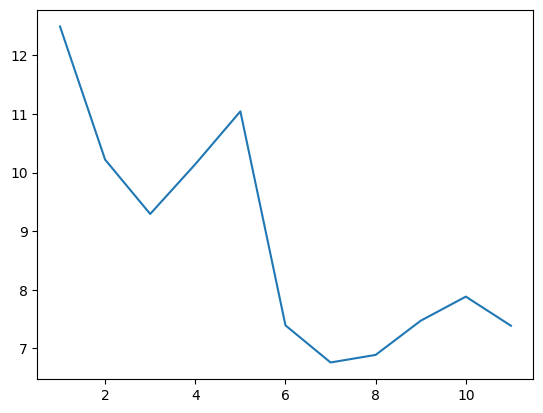

In [23]:
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count, y=history_ppl)
plt.show()

### Generación de secuencias

In [24]:
def generate_seq(model, seed_text, max_length, n_words):
    '''
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    '''
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower()]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded, verbose=0)[0, -1, :])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [35]:
input_text = 'computers hav'
generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'computers have the simple the thing the thi'

### Beam search y muestreo aleatorio

In [26]:
# Funciones para hacer encoding y decoding.

def encode(text, max_length=max_context_size):
    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model, num_beams, num_words, input, temp=1, mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0, -1, :]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0] * num_beams
    history_tokens = [encoded[0]] * num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [31]:
# Predicción con beam search
salidas = beam_search(model, num_beams=10, num_words=20, input='when i was a child')

In [32]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 28, 21, 25,
       35, 47, 13, 47, 28, 10, 43, 47, 10, 47,  3, 21, 13, 17, 31, 29, 25,
       35, 47, 13, 35, 47, 30, 21, 25, 47,  3,  0, 14, 54, 11, 30, 25, 29,
       47])

In [33]:
# Decode de las salidas.
decode(salidas[0])

'oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooowhen i was a children in the computer '